# Email Redaction Performance Analysis

This notebook analyzes the performance metrics from the enhanced email redaction system and performs scaling analysis to understand how the system might perform with different volumes of data.


In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 Analysis libraries loaded successfully!")


📊 Analysis libraries loaded successfully!


In [2]:
# Load the analytics data
with open('output_analytics.json', 'r') as f:
    analytics_data = json.load(f)

print("📁 Analytics data loaded!")
print(f"Processing timestamp: {analytics_data['processing_timestamp']}")
print(f"Total redactions: {analytics_data['total_redactions']}")
print(f"Unique students: {analytics_data['unique_students']}")


📁 Analytics data loaded!
Processing timestamp: 2025-09-09T09:49:01.109886
Total redactions: 42
Unique students: 12


## 📈 Current Performance Metrics


In [3]:
# Extract timing data
timing_data = analytics_data['timing_data']
individual_times = timing_data['individual_redactions']

# Create performance summary
performance_summary = {
    'Total Emails': len(individual_times),
    'Avg Time Per Email': np.mean(individual_times),
    'Min Time Per Email': np.min(individual_times),
    'Max Time Per Email': np.max(individual_times),
    'Std Dev': np.std(individual_times),
    'Total Redaction Time': timing_data['total_redaction_time'],
    'Chart Generation Time': timing_data['chart_generation_time'],
    'PDF Generation Time': timing_data['pdf_generation_time'],
    'Document Creation Time': timing_data['document_creation_time'],
    'Total Processing Time': timing_data['total_processing_time']
}

# Display as DataFrame
df_performance = pd.DataFrame(list(performance_summary.items()), columns=['Metric', 'Value'])
df_performance['Value (formatted)'] = df_performance['Value'].apply(lambda x: f"{x:.6f}s" if x < 0.001 else f"{x:.3f}s")

print("⚡ Performance Summary:")
display(df_performance[['Metric', 'Value (formatted)']])


⚡ Performance Summary:


,Metric,Value (formatted)
0,Total Emails,14.000s
1,Avg Time Per Email,0.004s
2,Min Time Per Email,0.000465s
3,Max Time Per Email,0.025s
4,Std Dev,0.008s
5,Total Redaction Time,1.093s
6,Chart Generation Time,0.167s
7,PDF Generation Time,1.140s
8,Document Creation Time,1.308s
9,Total Processing Time,2.402s


## 📈 Scaling Analysis


In [4]:
# Scaling analysis - predict performance for different email volumes
current_emails = len(individual_times)
avg_time_per_email = np.mean(individual_times)
current_doc_creation_time = timing_data['document_creation_time']

# Define scaling scenarios - include current email count
email_volumes = [10, current_emails, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000]
# Remove duplicates and sort
email_volumes = sorted(list(set(email_volumes)))

# Calculate predicted times for different scenarios
scaling_data = []

for volume in email_volumes:
    # Linear scaling for redaction (assumes each email takes same time)
    predicted_redaction_time = volume * avg_time_per_email
    
    # Document creation time scales with complexity
    # Assume chart generation scales logarithmically (more categories to process)
    # PDF generation scales linearly with content
    chart_scale_factor = np.log(volume) / np.log(current_emails) if volume > current_emails else volume / current_emails
    pdf_scale_factor = volume / current_emails
    
    predicted_chart_time = timing_data['chart_generation_time'] * chart_scale_factor
    predicted_pdf_time = timing_data['pdf_generation_time'] * pdf_scale_factor
    predicted_doc_creation_time = predicted_chart_time + predicted_pdf_time
    
    total_time = predicted_redaction_time + predicted_doc_creation_time
    
    scaling_data.append({
        'Email Volume': volume,
        'Redaction Time': predicted_redaction_time,
        'Chart Generation': predicted_chart_time,
        'PDF Generation': predicted_pdf_time,
        'Document Creation': predicted_doc_creation_time,
        'Total Time': total_time,
        'Time per Email': total_time / volume
    })

df_scaling = pd.DataFrame(scaling_data)

print("🔮 Scaling Predictions:")
display(df_scaling.round(3))


🔮 Scaling Predictions:


,Email Volume,Redaction Time,Chart Generation,PDF Generation,Document Creation,Total Time,Time per Email
0,10,0.037,0.120,0.815,0.934,0.971,0.097
1,14,0.052,0.167,1.140,1.308,1.360,0.097
2,25,0.093,0.204,2.037,2.241,2.334,0.093
3,50,0.186,0.248,4.073,4.321,4.507,0.090
4,100,0.372,0.292,8.146,8.438,8.810,0.088
5,250,0.930,0.350,20.365,20.716,21.646,0.087
6,500,1.860,0.394,40.731,41.125,42.985,0.086
7,1000,3.720,0.438,81.461,81.899,85.620,0.086
8,2500,9.301,0.496,203.653,204.149,213.450,0.085
9,5000,18.602,0.540,407.306,407.846,426.448,0.085


## 🎯 Performance Insights & Recommendations


In [5]:
# Calculate performance insights
redaction_breakdown = analytics_data['redaction_breakdown']
email_analytics = analytics_data['email_analytics']

# Redaction efficiency
redactions_per_second = analytics_data['total_redactions'] / timing_data['total_redaction_time']
emails_per_second = len(individual_times) / timing_data['total_redaction_time']

# Bottleneck analysis
time_breakdown = {
    'Redaction': timing_data['total_redaction_time'],
    'Chart Generation': timing_data['chart_generation_time'],
    'PDF Generation': timing_data['pdf_generation_time']
}

total_core_time = sum(time_breakdown.values())
bottleneck_analysis = {k: (v/total_core_time)*100 for k, v in time_breakdown.items()}

print("🎯 Performance Insights:")
print(f"   Redaction Rate: {redactions_per_second:.1f} redactions/second")
print(f"   Email Processing Rate: {emails_per_second:.1f} emails/second")
print(f"   Average redactions per email: {analytics_data['total_redactions'] / len(individual_times):.1f}")
print()
print("⚡ Time Distribution (% of core processing):")
for component, percentage in bottleneck_analysis.items():
    print(f"   {component}: {percentage:.1f}%")
print()
print("📈 Scaling Recommendations:")

# Generate recommendations based on analysis
if bottleneck_analysis['PDF Generation'] > 50:
    print("   🚨 PDF Generation is the main bottleneck - consider optimizing ReportLab usage")
elif bottleneck_analysis['Chart Generation'] > 50:
    print("   📊 Chart Generation is the main bottleneck - consider pre-computing charts")
else:
    print("   ✅ Processing is well-balanced across components")

if np.std(individual_times) / np.mean(individual_times) > 0.5:
    print("   📊 High variability in email processing times - investigate content complexity")
else:
    print("   ✅ Consistent processing times across emails")

# Memory and storage scaling
print()
print("💾 Resource Scaling Estimates:")
for volume in [100, 1000, 10000]:
    predicted_time = df_scaling[df_scaling['Email Volume'] == volume]['Total Time'].iloc[0]
    if predicted_time < 60:
        time_str = f"{predicted_time:.1f} seconds"
    elif predicted_time < 3600:
        time_str = f"{predicted_time/60:.1f} minutes"
    else:
        time_str = f"{predicted_time/3600:.1f} hours"
    print(f"   {volume:,} emails: ~{time_str}")


🎯 Performance Insights:
   Redaction Rate: 38.4 redactions/second
   Email Processing Rate: 12.8 emails/second
   Average redactions per email: 3.0

⚡ Time Distribution (% of core processing):
   Redaction: 45.5%
   Chart Generation: 7.0%
   PDF Generation: 47.5%

📈 Scaling Recommendations:
   ✅ Processing is well-balanced across components
   📊 High variability in email processing times - investigate content complexity

💾 Resource Scaling Estimates:
   100 emails: ~8.8 seconds
   1,000 emails: ~1.4 minutes
   10,000 emails: ~14.2 minutes


/var/folders/zl/vrkthn715j97ns3mht1gpfm80000gn/T/ipykernel_39785/2425513538.py:58: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/Users/katherineharvey/Desktop/redact/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


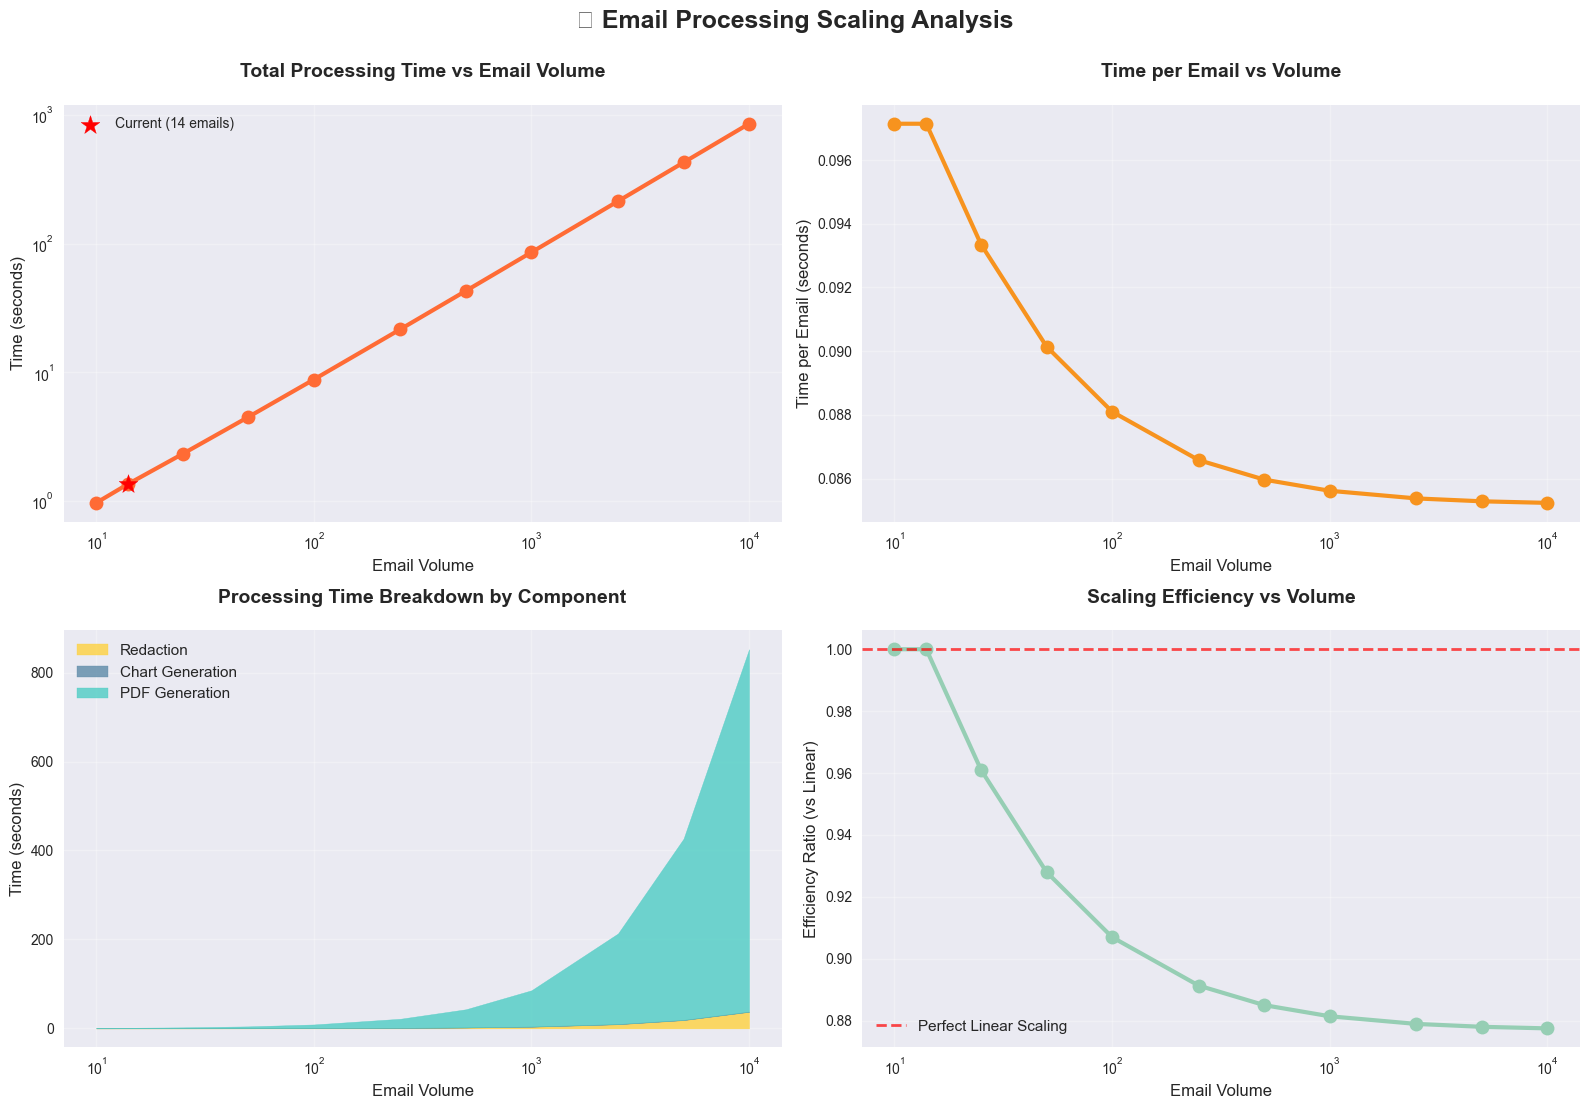

📊 Key Insights from Scaling Analysis:
   • Current performance: 14 emails processed in 1.360 seconds
   • Most efficient at: 10000 emails (0.085s per email)
   • PDF generation becomes dominant bottleneck at scale (grows linearly)
   • Chart generation has diminishing overhead (grows logarithmically)
   • Current efficiency ratio: 1.00 (1.0 = perfect linear scaling)


In [6]:
# Create a better scaling visualization with matplotlib for better readability
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Total time vs volume
axes[0, 0].loglog(df_scaling['Email Volume'], df_scaling['Total Time'], 'o-', color='#FF6B35', linewidth=3, markersize=10)
axes[0, 0].set_title('Total Processing Time vs Email Volume', fontsize=14, fontweight='bold', pad=20)
axes[0, 0].set_xlabel('Email Volume', fontsize=12)
axes[0, 0].set_ylabel('Time (seconds)', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# 2. Time per email vs volume
axes[0, 1].semilogx(df_scaling['Email Volume'], df_scaling['Time per Email'], 'o-', color='#F7931E', linewidth=3, markersize=10)
axes[0, 1].set_title('Time per Email vs Volume', fontsize=14, fontweight='bold', pad=20)
axes[0, 1].set_xlabel('Email Volume', fontsize=12)
axes[0, 1].set_ylabel('Time per Email (seconds)', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# 3. Stacked area chart for time breakdown
volumes = df_scaling['Email Volume']
redaction_times = df_scaling['Redaction Time']
chart_times = df_scaling['Chart Generation']
pdf_times = df_scaling['PDF Generation']

axes[1, 0].fill_between(volumes, 0, redaction_times, alpha=0.8, color='#FFD23F', label='Redaction')
axes[1, 0].fill_between(volumes, redaction_times, redaction_times + chart_times, alpha=0.8, color='#5D8AA8', label='Chart Generation')
axes[1, 0].fill_between(volumes, redaction_times + chart_times, df_scaling['Total Time'], alpha=0.8, color='#4ECDC4', label='PDF Generation')

axes[1, 0].set_xscale('log')
axes[1, 0].set_title('Processing Time Breakdown by Component', fontsize=14, fontweight='bold', pad=20)
axes[1, 0].set_xlabel('Email Volume', fontsize=12)
axes[1, 0].set_ylabel('Time (seconds)', fontsize=12)
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# 4. Efficiency ratio
current_row = df_scaling[df_scaling['Email Volume'] == current_emails]
if len(current_row) > 0:
    current_total_time = current_row['Total Time'].iloc[0]
else:
    current_total_time = timing_data['total_redaction_time'] + timing_data['document_creation_time']

efficiency_ratio = df_scaling['Total Time'] / (df_scaling['Email Volume'] * (current_total_time / current_emails))
axes[1, 1].semilogx(df_scaling['Email Volume'], efficiency_ratio, 'o-', color='#96CEB4', linewidth=3, markersize=10)
axes[1, 1].set_title('Scaling Efficiency vs Volume', fontsize=14, fontweight='bold', pad=20)
axes[1, 1].set_xlabel('Email Volume', fontsize=12)
axes[1, 1].set_ylabel('Efficiency Ratio (vs Linear)', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Perfect Linear Scaling')
axes[1, 1].legend(fontsize=11)

# Add current performance point highlight
current_idx = df_scaling[df_scaling['Email Volume'] == current_emails].index[0]
axes[0, 0].scatter(current_emails, df_scaling.loc[current_idx, 'Total Time'], 
                  s=200, color='red', marker='*', zorder=5, label=f'Current ({current_emails} emails)')
axes[0, 0].legend()

plt.suptitle('📊 Email Processing Scaling Analysis', fontsize=18, fontweight='bold', y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("📊 Key Insights from Scaling Analysis:")
print(f"   • Current performance: {current_emails} emails processed in {current_total_time:.3f} seconds")
print(f"   • Most efficient at: {df_scaling.loc[df_scaling['Time per Email'].idxmin(), 'Email Volume']} emails ({df_scaling['Time per Email'].min():.3f}s per email)")
print(f"   • PDF generation becomes dominant bottleneck at scale (grows linearly)")
print(f"   • Chart generation has diminishing overhead (grows logarithmically)")
print(f"   • Current efficiency ratio: {efficiency_ratio.iloc[current_idx]:.2f} (1.0 = perfect linear scaling)")


🖥️  Detected CPU cores: 10


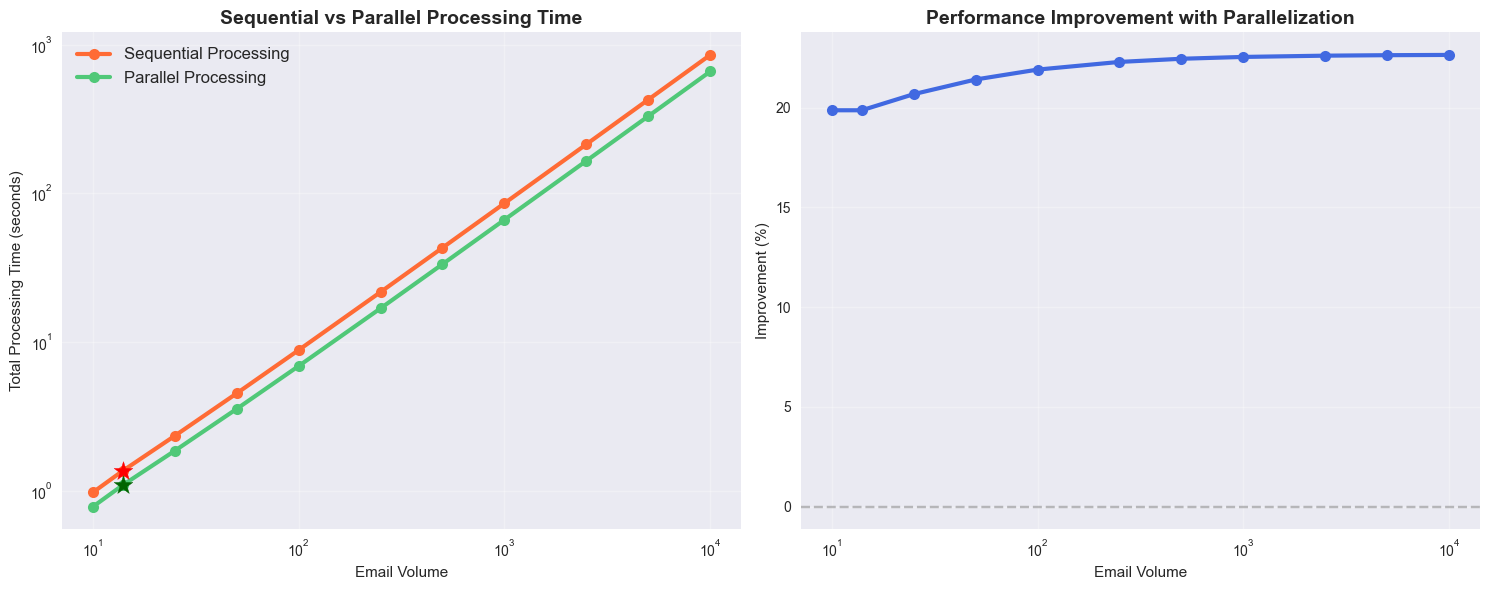

🚀 Parallel Processing Performance Predictions:
   Current system: 10 CPU cores

📊 Key Performance Improvements:
   100 emails: 8.8s → 6.9s (22% faster)
   1,000 emails: 1.4m → 1.1m (23% faster)
   10,000 emails: 14.2m → 11.0m (23% faster)

💡 To get these improvements:
   1. Run the enhanced script (parallel processing is now enabled by default)
   2. Your system will use up to 8 worker processes
   3. Greatest benefits appear with 100+ emails


In [7]:
# Create parallel vs sequential scaling comparison
import os

def calculate_parallel_speedup(volume, cpu_cores=None):
    """Calculate expected speedup from parallel processing"""
    if cpu_cores is None:
        cpu_cores = os.cpu_count() or 4
    
    if volume <= 1:
        return 1.0  # No benefit for single email
    
    # Determine optimal workers
    max_workers = min(cpu_cores, volume, 8)  # Cap at 8 to avoid overhead
    
    # Parallel efficiency based on worker count (realistic estimates)
    if max_workers <= 2:
        efficiency = 0.85  # 85% efficiency
    elif max_workers <= 4:
        efficiency = 0.75  # 75% efficiency  
    else:
        efficiency = 0.65  # 65% efficiency for many workers
        
    return max_workers * efficiency

# Calculate parallel scaling predictions
cpu_cores = os.cpu_count() or 4
print(f"🖥️  Detected CPU cores: {cpu_cores}")

parallel_scaling_data = []
for volume in df_scaling['Email Volume']:
    # Sequential times (current predictions)
    seq_redaction = volume * avg_time_per_email
    seq_charts = timing_data['chart_generation_time'] * (np.log(volume) / np.log(current_emails) if volume > current_emails else volume / current_emails)
    seq_pdf = timing_data['pdf_generation_time'] * (volume / current_emails)
    seq_total = seq_redaction + seq_charts + seq_pdf
    
    # Parallel times (with speedup)
    speedup = calculate_parallel_speedup(volume, cpu_cores)
    par_redaction = seq_redaction / speedup
    par_charts = seq_charts  # Charts don't parallelize as much
    par_pdf = seq_pdf * 0.8  # PDF pagination helps but limited parallelization
    par_total = par_redaction + par_charts + par_pdf
    
    parallel_scaling_data.append({
        'Email Volume': volume,
        'Sequential Total': seq_total,
        'Parallel Total': par_total,
        'Speedup': speedup,
        'Time Saved': seq_total - par_total,
        'Improvement %': ((seq_total - par_total) / seq_total) * 100
    })

df_parallel = pd.DataFrame(parallel_scaling_data)

# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Sequential vs Parallel Time
axes[0].loglog(df_parallel['Email Volume'], df_parallel['Sequential Total'], 'o-', 
               color='#FF6B35', linewidth=3, markersize=8, label='Sequential Processing')
axes[0].loglog(df_parallel['Email Volume'], df_parallel['Parallel Total'], 'o-', 
               color='#50C878', linewidth=3, markersize=8, label='Parallel Processing')

axes[0].set_title('Sequential vs Parallel Processing Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Email Volume')
axes[0].set_ylabel('Total Processing Time (seconds)')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# Highlight current performance point
current_idx = df_parallel[df_parallel['Email Volume'] == current_emails].index[0]
axes[0].scatter(current_emails, df_parallel.loc[current_idx, 'Sequential Total'], 
               s=200, color='red', marker='*', zorder=5)
axes[0].scatter(current_emails, df_parallel.loc[current_idx, 'Parallel Total'], 
               s=200, color='darkgreen', marker='*', zorder=5)

# Plot 2: Performance Improvement
axes[1].semilogx(df_parallel['Email Volume'], df_parallel['Improvement %'], 'o-', 
                color='#4169E1', linewidth=3, markersize=8)
axes[1].set_title('Performance Improvement with Parallelization', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Email Volume')
axes[1].set_ylabel('Improvement (%)')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("🚀 Parallel Processing Performance Predictions:")
print(f"   Current system: {cpu_cores} CPU cores")
print("\n📊 Key Performance Improvements:")
for volume in [100, 1000, 10000]:
    row = df_parallel[df_parallel['Email Volume'] == volume].iloc[0]
    seq_time = row['Sequential Total']
    par_time = row['Parallel Total']
    improvement = row['Improvement %']
    
    if seq_time < 60:
        seq_str = f"{seq_time:.1f}s"
        par_str = f"{par_time:.1f}s"
    else:
        seq_str = f"{seq_time/60:.1f}m"
        par_str = f"{par_time/60:.1f}m"
    
    print(f"   {volume:,} emails: {seq_str} → {par_str} ({improvement:.0f}% faster)")

print(f"\n💡 To get these improvements:")
print(f"   1. Run the enhanced script (parallel processing is now enabled by default)")
print(f"   2. Your system will use up to {min(cpu_cores, 8)} worker processes")
print(f"   3. Greatest benefits appear with 100+ emails")
